# Moving Averages CINGULATE region

### 1) Imports

In [1]:
import os
import glob
import sys

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

In [2]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

from datasets import SkeletonDataset
import torch
from vae import *

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn import metrics

import matplotlib.cm as cm

In [3]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(1, len(df.columns)+1)]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [4]:
path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'

### 2) Loading of subjects's distribution in the latent space
DataFrame is obtained during analysis of beta-VAE latent space (2 dimensions) for CINGULATE crops, according to the following steps:
- loading of trained model
- encoding of test controls and asymmetry benchmark subjects

In [5]:
if torch.cuda.is_available():
    device = "cuda:0"

In [6]:
model_dir = '/neurospin/dico/lguillon/midl_22/new_design/gridsearch/n_2_kl_2/'
model = VAE((1, 20, 40, 40), 2, depth=3)
model.load_state_dict(torch.load(model_dir + 'checkpoint.pt'))
model = model.to(device)

In [7]:
subject_dir = "/neurospin/dico/data/deep_folding/current/"
data_dir = "/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/"

train_list = pd.read_csv(os.path.join(subject_dir,
                         f"HCP_half_{1}bis.csv"), header=None,
                         usecols=[0], names=['subjects'])

train_list['subjects'] = train_list['subjects'].astype('str')

tmp = pd.read_pickle(os.path.join(data_dir, "Rskeleton.pkl")).T
#tmp = tmp.rename(columns={0:'subjects'})
tmp.index.astype('str')

tmp = tmp.merge(train_list, left_on = tmp.index, right_on='subjects', how='right')

filenames = list(train_list['subjects'])

subset = SkeletonDataset(dataframe=tmp, filenames=filenames)

In [8]:
dataloader = torch.utils.data.DataLoader(
              subset,
              batch_size=64,
              num_workers=8,
              shuffle=True)    

In [9]:
dico_set_loaders = {'data': dataloader}

root_dir = '/neurospin/dico/lguillon/midl_22/new_design/analysis/n_2_kl_2/'

weights = [1, 2]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=4, depth=3, root_dir=root_dir)

In [10]:
results = tester.test()
encoded = {loader_name:[results[loader_name][k] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
df_encoded = pd.DataFrame()
df_encoded['latent'] = encoded['data']
X = np.array(list(df_encoded['latent']))
labels = list(results['data'].keys())

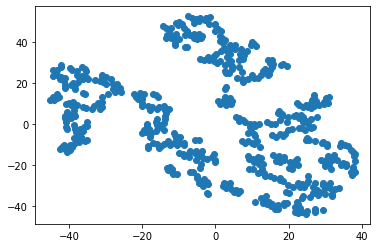

In [11]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=15).fit_transform(X)

x = [X_embedded[k][0] for k in range(len(X_embedded))]
y = [X_embedded[k][1] for k in range(len(X_embedded))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)

In [12]:
af = AffinityPropagation(random_state=15, max_iter=1000).fit(X_embedded)
cluster_labels_ini = af.labels_
initial_centers = af.cluster_centers_indices_
n_clusters_ = len(initial_centers)
print(n_clusters_)
x_cluster_label = af.predict(X_embedded)
while n_clusters_ > 7:
    af = AffinityPropagation(random_state=0).fit(X_embedded[af.cluster_centers_indices_])
    center_cluster_labels = af.labels_
    x_cluster_label = af.predict(X_embedded)
    n_clusters_ = len(af.cluster_centers_indices_)
    print(n_clusters_)
    clusters_centroids = af.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

18
4
cluster's centroids coordinates: 
 [[  9.674993   -3.453913 ]
 [  4.2440395  36.812496 ]
 [-38.597313    6.9115453]
 [ 16.460104  -17.892948 ]]


In [13]:
dstrb_sub = pd.DataFrame(X_embedded, index=labels, columns=[1, 2])
dstrb_sub['cluster_lab'] = x_cluster_label

In [14]:
cluster1 = dstrb_sub[dstrb_sub.cluster_lab==0]
cluster2 = dstrb_sub[dstrb_sub.cluster_lab==1]
cluster3 = dstrb_sub[dstrb_sub.cluster_lab==2]
cluster4 = dstrb_sub[dstrb_sub.cluster_lab==3]
assert(len(np.unique(list(cluster1.cluster_lab)))==1)
assert(len(np.unique(list(cluster2.cluster_lab)))==1)
assert(len(np.unique(list(cluster3.cluster_lab)))==1)
assert(len(np.unique(list(cluster4.cluster_lab)))==1)

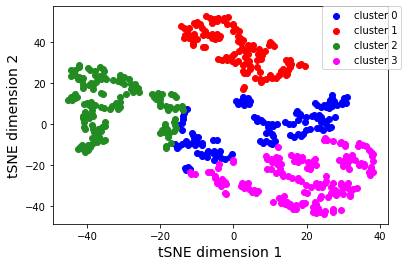

In [15]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[:2]]) for i in range(len(dstrb_sub))])

color_dict = {0:'blue',1: 'red', 2:'forestgreen', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.cluster_lab]):
    ix = np.where(dstrb_sub.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [16]:
central_1 = closest_distance(clusters_centroids[0], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 1 is {central_1}")
central_2 = closest_distance(clusters_centroids[1], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 2 is {central_2}")
central_3 = closest_distance(clusters_centroids[2], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 3 is {central_3}")
central_4 = closest_distance(clusters_centroids[3], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 4 is {central_4}")

Closest subject to centroid of cluster 1 is 213522
Closest subject to centroid of cluster 2 is 633847
Closest subject to centroid of cluster 3 is 804646
Closest subject to centroid of cluster 4 is 720337


### Creation of buckets dictionnary

In [17]:
bucket_path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rbuckets/'
suffix_path = '_normalized.bck'
buckets = {}
for sub in tqdm(list(labels)):
    bucket = aims.read(os.path.join(bucket_path, str(sub) + suffix_path))
    bucket = dtx.convert.bucket_aims_to_ndarray(bucket[0])
    buckets[sub] = bucket

100%|██████████| 550/550 [00:46<00:00, 11.95it/s]


In [18]:
subjects_c1 = cluster1.index
subjects_c2 = cluster2.index
subjects_c3 = cluster3.index
subjects_c4 = cluster4.index

buckets_c1 = {k: v for k,v in buckets.items() if k in list(subjects_c1)}
buckets_c2 = {k: v for k,v in buckets.items() if k in list(subjects_c2)}
buckets_c3 = {k: v for k,v in buckets.items() if k in list(subjects_c3)}
buckets_c4 = {k: v for k,v in buckets.items() if k in list(subjects_c4)}

#### Alignement of the subjects to respective central subject

In [26]:
aligned_buckets_C1, aligned_rot_C1, aligned_transl_C1 = ma.align_buckets_by_ICP_batch(buckets_c1, central_1)
aligned_buckets_C2, aligned_rot_C2, aligned_transl_C2 = ma.align_buckets_by_ICP_batch(buckets_c2, central_2)
aligned_buckets_C3, aligned_rot_C3, aligned_transl_C3 = ma.align_buckets_by_ICP_batch(buckets_c3, central_3)

>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 167036: 100%|██████████| 152/152 [00:02<00:00, 58.69it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 919966: 100%|██████████| 142/142 [00:02<00:00, 53.13it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 168038: 100%|██████████| 256/256 [00:05<00:00, 50.21it/s] 


In [27]:
def subj_count_extreme_coords(isodf, axis, min_coord, max_coord, num_coord=5):
    coord_values = np.linspace(min_coord, max_coord, num_coord)
    step = (coord_values[1] - coord_values[0])
    midpoint_min = coord_values[0] + step/2
    midpoint_max = coord_values[num_coord-1] - step/2
    coord_under = [elt for elt in isodf[axis] if elt<midpoint_min]
    coord_over = [elt for elt in isodf[axis] if elt>midpoint_max]
    num_subj_under = len(coord_under)
    num_subj_over = len(coord_over)
    return num_subj_under, num_subj_over

def get_MA_coords(isodf, axis, num_subj_threshold, num_coord=5):
    min_subj_coord = min(isodf[axis])
    max_subj_coord = max(isodf[axis])
    step = (max_subj_coord - min_subj_coord)/num_coord
    num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    while ((num_subj_under<num_subj_threshold)|(num_subj_over<num_subj_threshold)):
        step = (max_subj_coord - min_subj_coord)/num_coord
        if num_subj_under<num_subj_threshold:
            min_subj_coord = min_subj_coord + step
        if num_subj_over<num_subj_threshold:
            max_subj_coord = max_subj_coord - step
        num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    return np.linspace(min_subj_coord, max_subj_coord, num_coord)

### TSNE AXIS 1 analysis

In [28]:
MA_coords_1 = [dstrb_sub.loc[central_1][1]]
MA_coords_2 = [dstrb_sub.loc[central_2][1]]
MA_coords_3 = [dstrb_sub.loc[central_3][1]]

#### Parameters

In [29]:
fwhm = 10
thresh = 90
axis = 1

#### Cluster 1

In [30]:
SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(MA_coords_1, aligned_buckets_C1, cluster1, axis_n=axis, FWHM=fwhm)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


In [36]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=0.5)
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_cluster_1_n2.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 98.59it/s]


#### Cluster 2

In [37]:
SPAM_vols_c2, shift2 = ma.calc_MA_volumes_batch(MA_coords_2, aligned_buckets_C2, cluster2, axis_n=axis, FWHM=fwhm)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


In [41]:
SPAM_meshes_2 = {}

for k, volume in tqdm(list(SPAM_vols_c2.items())[:]):
    SPAM_meshes_2[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=0.6)
    
shifted_SPAM_meshes_2 = {}
for dist, mesh in SPAM_meshes_2.items():
    shifted_SPAM_meshes_2[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_2.items()):
    aims.write(mesh, f"MA_cluster_2_n2.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 97.11it/s]


#### Cluster 3

In [42]:
SPAM_vols_c3, shift3 = ma.calc_MA_volumes_batch(MA_coords_3, aligned_buckets_C3, cluster3, axis_n=axis, FWHM=fwhm)

Calculating moving averages: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


In [49]:
SPAM_meshes_3 = {}

for k, volume in tqdm(list(SPAM_vols_c3.items())[:]):
    SPAM_meshes_3[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=0.6)
    
shifted_SPAM_meshes_3 = {}
for dist, mesh in SPAM_meshes_3.items():
    shifted_SPAM_meshes_3[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_3.items()):
    aims.write(mesh, f"MA_cluster_3_n2.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 84.60it/s]


### Replication half 2

In [19]:
model_dir = '/neurospin/dico/lguillon/midl_22/new_design/half2/n_2_kl_2/'
model_2 = VAE((1, 20, 40, 40), 2, depth=3)
model_2.load_state_dict(torch.load(model_dir + 'checkpoint.pt'))
model_2 = model_2.to(device)

In [20]:
root_dir = '/neurospin/dico/lguillon/midl_22/new_design/analysis/model_2_n_2_kl_2/'

weights = [1, 2]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester = ModelTester(model=model_2, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=2, depth=3, root_dir=root_dir)

In [21]:
results_2 = tester.test()
encoded_2 = {loader_name:[results_2[loader_name][k] for k in results_2[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
df_encoded_2 = pd.DataFrame()
df_encoded_2['latent'] = encoded_2['data']
X_2 = np.array(list(df_encoded_2['latent']))
labels_2 = list(results_2['data'].keys())

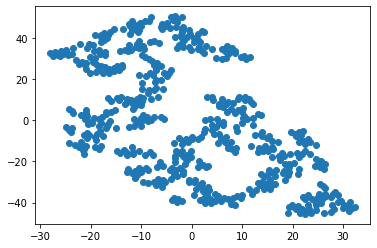

In [40]:
X_embedded_2 = TSNE(n_components=2, perplexity=20).fit_transform(X_2)

x = [X_embedded_2[k][0] for k in range(len(X_embedded_2))]
y = [X_embedded_2[k][1] for k in range(len(X_embedded_2))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)

In [41]:
af = AffinityPropagation(random_state=20, max_iter=1000).fit(X_embedded_2)
cluster_labels_ini = af.labels_
initial_centers = af.cluster_centers_indices_
n_clusters_ = len(initial_centers)
print(n_clusters_)
x_cluster_label = af.predict(X_embedded_2)
while n_clusters_ > 7:
    af = AffinityPropagation(random_state=0).fit(X_embedded_2[af.cluster_centers_indices_])
    center_cluster_labels = af.labels_
    x_cluster_label = af.predict(X_embedded_2)
    n_clusters_ = len(af.cluster_centers_indices_)
    print(n_clusters_)
    clusters_centroids = af.cluster_centers_

17
4


In [42]:
dstrb_sub_2 = pd.DataFrame(X_embedded_2, index=labels_2, columns=[1, 2])
dstrb_sub_2['cluster_lab_half2'] = x_cluster_label
dstrb_sub_2['subjects'] = dstrb_sub_2.index

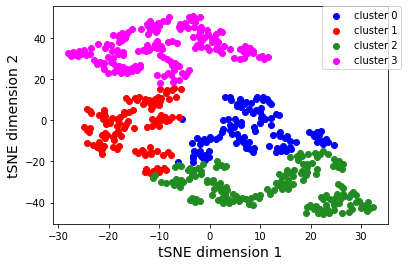

In [43]:
arr = np.array([np.array([dstrb_sub_2[k][i] for k in dstrb_sub_2.columns[:2]]) for i in range(len(dstrb_sub_2))])

color_dict = {0:'blue',1: 'red', 2:'forestgreen', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub_2.cluster_lab_half2]):
    ix = np.where(dstrb_sub_2.cluster_lab_half2 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [44]:
m1 = pd.merge(dstrb_sub, dstrb_sub_2, left_on=dstrb_sub.index, right_on=dstrb_sub_2.subjects)

In [45]:
m1.head()

,key_0,1_x,2_x,cluster_lab,1_y,2_y,cluster_lab_half2,subjects
0,113619,-0.112555,-18.661516,3,-16.628414,-1.565072,1,113619
1,196144,-3.085064,31.033600,1,4.512649,-6.829263,0,196144
2,620434,-2.591936,51.621922,1,10.343232,31.334585,3,620434
3,120010,10.672189,-9.753501,0,-3.102041,-24.190535,2,120010
4,161832,-39.478191,18.847076,2,-20.143698,23.227110,3,161832


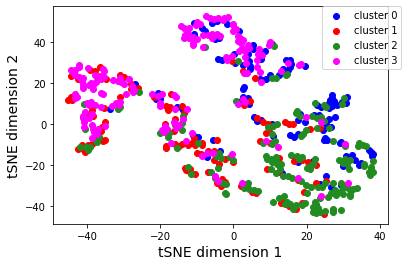

In [46]:
arr = np.array([np.array([m1[k][i] for k in m1.columns[1:3]]) for i in range(len(m1))])

color_dict = {0:'blue',1: 'red', 2:'forestgreen', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m1.cluster_lab_half2]):
    ix = np.where(m1.cluster_lab_half2 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

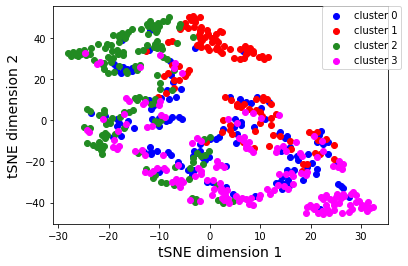

In [47]:
arr = np.array([np.array([m1[k][i] for k in m1.columns[4:6]]) for i in range(len(m1))])

color_dict = {0:'blue',1: 'red', 2:'forestgreen', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m1.cluster_lab]):
    ix = np.where(m1.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()